# Previsione della qualità di vini sulla base delle loro caratteristiche chimiche

Progetto di Programmazione di Applicazioni Data Intensive a.a. 2022/2023

Studente: Davide Picchiotti (davide.picchiotti@studio.unibo.it)


Lo scopo del progetto proposto è quello di addestrare un modello che sia in grado di predire un punteggio da 1 a 10 assegnato ad alcuni vini rossi Portoghesi, sulla base delle loro caratteristiche chimiche (solfati presenti, pH ecc).
Inizialmente il progetto doveva trovare la regressione, ma come vedremo alla fine, sarà necessario un cambio di approccio per avere dei risultati accettabili.

Importiamo le librerie standard (pandas per la gestione dei dati, matplotlib e seaborn per i grafici)

In [2]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Caricamento e descrizione del dataset
Carichiamo i dati da un file .csv e per comodità rinominiamo alcune colonne, rimuovendo gli spazi

In [196]:
data = pandas.read_csv("winequality-red.csv")
data = data.rename(columns={"fixed acidity":"fixed_acidity",
                            "volatile acidity":"volatile_acidity",
                            "citric acid":"citric_acid",
                            "residual sugar":"residual_sugar",
                            "free sulfur dioxide":"free_sulfur_dioxide",
                            "total sulfur dioxide":"total_sulfur_dioxide"})

data.head(3)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


Di seguito i significati delle colonne, estratti direttamente dalla fonte del dataset (https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)

- fixed acidity: most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
- volatile acidity: the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
- citric acid: found in small quantities, citric acid can add 'freshness' and flavor to wines
- residual sugar: the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet
- chlorides: the amount of salt in the wine
- free sulfur dioxide: the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine
- total sulfur dioxide: amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine
- density: the density of water is close to that of water depending on the percent alcohol and sugar content
- pH: describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale
- sulphates: a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant
- alcohol: the percent alcohol content of the wine
- quality: based on sensory data, score between 0 and 10

La nostra variabile target è 'quality'.

In [197]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Come possiamo evincere dall'output di info(), il dataset non ha record nulli e conta 1599 istanze.

Definiamo qua una funzione per il disegno dei grafici che ci servirà più avanti.

In [5]:
def boxplot_n_histogram(dataset, column):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15, 7))
    axes[0].boxplot(dataset[column], showmeans=True)
    axes[1].hist(dataset[column])
    
    axes[0].set_title(column)
    axes[1].set_title(column)

## Esplorazione ed analisi dei dati

Analizziamo la distribuzione della variabile target

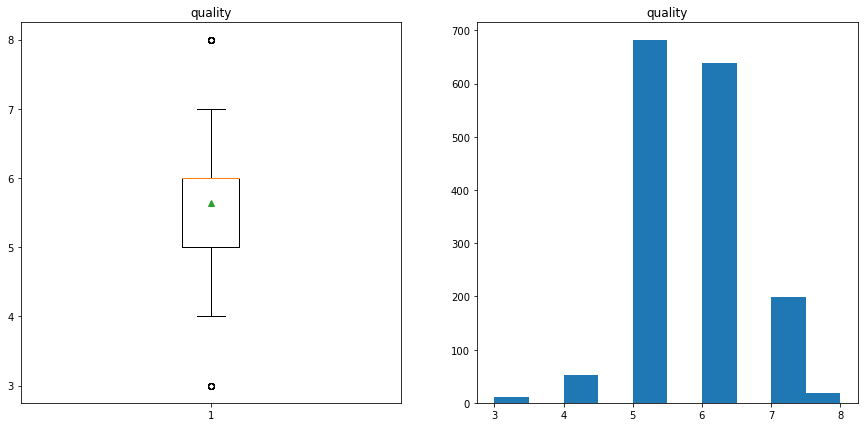

In [199]:
boxplot_n_histogram(data, "quality")

In [ ]:
data["quality"].describe()

count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

Dai grafici e dall'output di describe(), notiamo quanto la distribuzione di 'quality' sia sbilanciata.
Questo potrebbe dare alcuni problemi nell'addestramento dei modelli, è bene tenerlo a mente.
In particolare, buona parte dei vini giudicati nel dataset hanno ricevuto un punteggio di 5 o 6.

Analizziamo alcuni scatter plot di features vs. quality, per vedere se ne risulta qualche osservazione interessante.

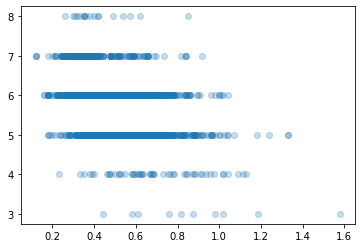

In [20]:
plt.scatter(data["volatile_acidity"], data["quality"], alpha=0.25)

In [201]:
data["volatile_acidity"].describe()

count    1599.000000
mean        0.527821
std         0.179060
min         0.120000
25%         0.390000
50%         0.520000
75%         0.640000
max         1.580000
Name: volatile_acidity, dtype: float64

Possiamo notare come all'aumentare della qualità, il range di valori di 'volatile_acidity' si restringe.

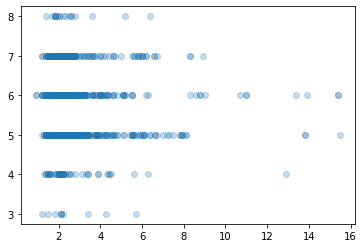

In [22]:
plt.scatter(data["residual_sugar"], data["quality"], alpha=0.25)

In [202]:
data["residual_sugar"].describe()

count    1599.000000
mean        2.538806
std         1.409928
min         0.900000
25%         1.900000
50%         2.200000
75%         2.600000
max        15.500000
Name: residual_sugar, dtype: float64

Possiamo anche notare come al crescere della qualità i vini siano tendenzialmente meno dolci.

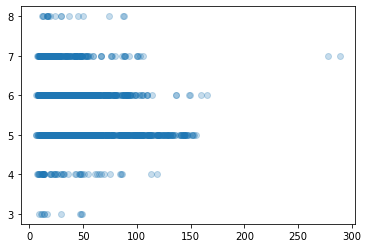

In [25]:
plt.scatter(data["total_sulfur_dioxide"], data["quality"], alpha=0.25)

Al crescere della qualità diminuiscono anche i livelli di anidride solforosa.

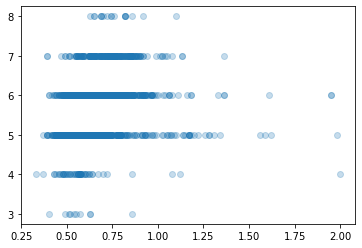

In [28]:
plt.scatter(data["sulphates"], data["quality"], alpha=0.25)

All'aumentare dei solfati la qualità del vino sembra aumentare.

Stampiamo una matrice di correlazione per capire quali sono le variabili più correlate alla variabile target, oltre a capire se c'è collinearità tra la variabili indipendenti

<AxesSubplot:>

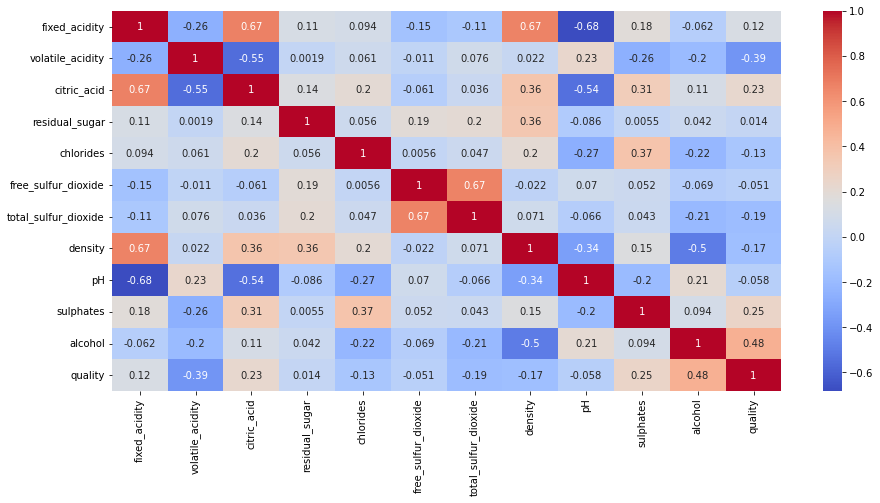

In [29]:
plt.subplots(figsize=(15,7))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")

Notiamo forte correlazione tra:
- 'free_sulphur_dioxide' e 'total_sulphur_dioxide'
- 'fixed_acidity' e 'citric_acid'

## Definizione funzioni di utility e preprocessing

In [62]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy

random_state = 50

def relative_error(y_true, y_pred):
    return numpy.mean(numpy.abs((y_true - y_pred) / y_true))
def rmspe(y_real, y_pred):
    return numpy.sqrt(numpy.mean((y_pred /y_real - 1) ** 2))

def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = relative_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"Mean squared error: {mse:.5}")
    print(f"RMSPE: {rmspe(y, preds):12.4f}")
    print(f"Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

Dividiamo i dati tra variabili indipendenti e la variabile dipendente, oltre a preparare un KFold che ci servirà più avanti.
Prepariamo anche un training set e un validation set.

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold, cross_validate, GridSearchCV, train_test_split

x = data.drop(columns="quality")
y = data["quality"]
kf = KFold(5, shuffle=True, random_state=random_state)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=random_state)

## Regressione lineare con normalizzazione e cross validation

Iniziamo provando un modello di regressione lineare con normalizzazione delle variabili di input.
A questo scopo costruiamo una pipeline con due componenti.
Di seguito lo addestriamo sui dati di training e stampiamo le metriche sui dati di validation.

In [32]:
linear_model = Pipeline([
    ("scaler", StandardScaler()), 
    ("linreg", LinearRegression()
     )])

linear_model.fit(x_train, y_train)
print_eval(x_test, y_test, linear_model)

   Mean squared error: 0.40213
       Relative error: 9.20274%
R-squared coefficient: 0.32752


Calcoliamo la precisione del modello anche con la cross validation, più rappresentativa rispetto al metodo di hold-out.

In [33]:
linear_model = Pipeline([
    ("scaler", StandardScaler()), 
    ("linreg", LinearRegression()
     )])

cv_res = cross_validate(linear_model, x, y, cv=kf)
cv_frame = pandas.DataFrame(cv_res)
cv_frame["test_score"].mean()

0.34212132449474336

Notiamo come la precisione del modello non sia particolarmente soddisfacente, probabilmente dovuto al fatto che alcune variabili indipendenti sono in realtà collineari e la distribuzione non è ottimale.

## Regressione Ridge con grid search

Analizziamo gli effetti di regolarizzazione dell'algoritmo Ridge, sfruttando il metodo della grid search per dimensionare l'iperparametro alpha.

In [34]:
ridge_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])
grid = {"ridge__alpha":[0.1, 1, 10, 30, 50]}
gs_res = GridSearchCV(ridge_model, param_grid=grid, cv=kf)
gs_res.fit(x_train, y_train)

print_eval(x_test, y_test, gs_res)
pandas.DataFrame(gs_res.cv_results_)

   Mean squared error: 0.40006
       Relative error: 9.22113%
R-squared coefficient: 0.33098


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007399,0.010306,0.000801,4.002575e-04,0.1,{'ridge__alpha': 0.1},0.272479,0.318111,0.358342,0.418788,0.353036,0.344151,0.048303,5
1,0.002800,0.000400,0.001200,4.000664e-04,1,{'ridge__alpha': 1},0.272575,0.318457,0.358375,0.418761,0.353000,0.344233,0.048230,4
2,0.002799,0.000400,0.001000,2.336015e-07,10,{'ridge__alpha': 10},0.273511,0.321315,0.358633,0.418414,0.352669,0.344908,0.047552,3
3,0.002600,0.000489,0.000800,3.998521e-04,30,{'ridge__alpha': 30},0.275438,0.325180,0.358906,0.417239,0.351995,0.345752,0.046238,2
4,0.002600,0.000490,0.001000,5.761645e-07,50,{'ridge__alpha': 50},0.277106,0.327226,0.358943,0.415664,0.351321,0.346052,0.045051,1


Nonostante lo score maggiore sia con alpha=50, notiamo che la colonna 'mean_test_score' ha valori molto simili per tutti i valori di alpha.

Proviamo a calcolare la media degli score con cross validation.

In [204]:
ridge_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(1))
])

cv_res = cross_validate(ridge_model, x, y, cv=kf)
cv_frame = pandas.DataFrame(cv_res)
cv_frame["test_score"].mean()

0.34215071688479365

Il punteggio del modello è migliorato, ma non in maniera molto significativa.

La precisione dei primi due modelli testati non è soddisfacente.
Tentiamo con una regressione Lasso, siccome notiamo un alto indice di correlazione tra alcune della variabili indipendenti.

## Regressione Lasso con grid search

In [206]:
lasso_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso())
])
grid = {"lasso__alpha":[0.001, 0.004, 0.007, 0.05, 0.1]}
gs_res = GridSearchCV(lasso_model, param_grid=grid, cv=kf)
gs_res.fit(x_train, y_train)
pandas.DataFrame(gs_res.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002400,0.000488,0.0010,1.027139e-06,0.001,{'lasso__alpha': 0.001},0.274499,0.321387,0.359217,0.417790,0.353506,0.345280,0.047118,3
1,0.003400,0.000490,0.0010,6.323346e-04,0.004,{'lasso__alpha': 0.004},0.280009,0.325137,0.360670,0.414308,0.354452,0.346915,0.044133,2
2,0.003200,0.000400,0.0010,7.168434e-07,0.007,{'lasso__alpha': 0.007},0.284572,0.326289,0.361484,0.410163,0.354479,0.347398,0.041426,1
3,0.003000,0.000632,0.0008,3.999711e-04,0.05,{'lasso__alpha': 0.05},0.291687,0.308596,0.359335,0.360442,0.337379,0.331488,0.027411,4
4,0.002599,0.000800,0.0010,1.007019e-06,0.1,{'lasso__alpha': 0.1},0.276919,0.271773,0.333085,0.318463,0.304465,0.300941,0.023582,5


Utilizziamo il valore 0.007 poichè risulta essere il migliore.
Analizzando valori più alti di alpha si ottengono score decisamente troppo bassi; ciò è probabilmente dovuto al numero non troppo elevato di feature iniziali.
In seguito analizziamo i coefficienti ottenuti dall'addestramento del modello.

In [207]:
lasso_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(0.07))
])
lasso_model.fit(x_train, y_train)
lasso_coeff = pandas.Series(lasso_model.named_steps["lasso"].coef_, x_train.columns.values.tolist())
lasso_coeff

fixed_acidity           0.000000
volatile_acidity       -0.182886
citric_acid             0.000000
residual_sugar         -0.000000
chlorides              -0.000000
free_sulfur_dioxide    -0.000000
total_sulfur_dioxide   -0.007490
density                -0.000000
pH                     -0.000000
sulphates               0.059049
alcohol                 0.275815
dtype: float64

In [142]:
cv_res = cross_validate(lasso_model, x, y, cv=kf)
cv_frame = pandas.DataFrame(cv_res).sort_values("test_score", ascending=False)
cv_frame

,fit_time,score_time,test_score
3,0.002000,0.000999,0.344925
1,0.003000,0.001001,0.334712
4,0.001999,0.001002,0.305581
2,0.003000,0.000998,0.302402
0,0.003998,0.000998,0.279029


In [143]:
cv_frame["test_score"].mean()

0.31333000041445397

Lo score del modello è inferiore ai precedenti, ma abbiamo ottenuto alcune informazioni sulla rilevanza delle feature disponibili.
Proviamo intuitivamente a rimuovere le feature di poca importanza e riaddestrare un modello lineare con features polinomiali e regolarizzazione.

In [38]:
x_red = x.drop(columns=["fixed_acidity", "residual_sugar", "density", "citric_acid", "chlorides", "free_sulfur_dioxide", "pH"])
x_train_red = x_train.drop(columns=["fixed_acidity", "residual_sugar", "density", "citric_acid", "chlorides", "free_sulfur_dioxide", "pH"])
x_test_red = x_test.drop(columns=["fixed_acidity", "residual_sugar", "density", "citric_acid", "chlorides", "free_sulfur_dioxide", "pH"])

## Regressione Polinomiale su dataset con feature ridotte

In [39]:
linear_model = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression()
     )])
grid = {"poly__degree":[1, 2, 3]}
gs_res = GridSearchCV(linear_model, param_grid=grid, cv=kf)
gs_res.fit(x_train_red, y_train)
pandas.DataFrame(gs_res.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003801,0.001471,0.000799,0.000399,1,{'poly__degree': 1},0.283028,0.322699,0.349475,0.386477,0.350631,0.338462,0.034340,3
1,0.004625,0.002722,0.000974,0.000051,2,{'poly__degree': 2},0.348051,0.341285,0.429822,0.397502,0.337009,0.370734,0.036680,1
2,0.005001,0.003033,0.001000,0.000001,3,{'poly__degree': 3},0.358288,0.346214,0.354104,0.396677,0.272183,0.345493,0.040577,2


In [141]:
linear_model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()), 
    ("linreg", LinearRegression()
     )])
linear_model.fit(x_train_red, y_train)
print_eval(x_test_red, y_test, linear_model)

cv_res = cross_validate(linear_model, x_red, y, cv=kf)
cv_frame = pandas.DataFrame(cv_res).sort_values("test_score", ascending=False)
cv_frame

Mean squared error: 0.40966
RMSPE:       0.1295
Relative error: 9.40925%
R-squared coefficient: 0.31492


,fit_time,score_time,test_score
3,0.004000,0.001001,0.388583
4,0.003999,0.000999,0.381582
1,0.004000,0.000998,0.362635
2,0.003000,0.001000,0.335717
0,0.004002,0.000999,0.311070


In [139]:
cv_frame["test_score"].mean()

0.35591743104536505

Una regressione polinomiale di grado 2 aumenta leggermente lo score, ma siamo ancora lontani da un risultato soddisfacente.

A questo punto si potrebbero fare alcune prove con metodi basati su alberi di regressione (che includerò per completezza), ma qui mi rendo conto che il vero elefante nella stanza è la formulazione del problema.
E se fosse più adatto utilizzare questi dati per addestrare un modello di classificazione?

## Alberi di regressione

In [127]:
from sklearn.ensemble import RandomForestRegressor

rfm = RandomForestRegressor(max_samples=0.4, max_features="sqrt", n_estimators=200, max_depth=None, n_jobs=-1, random_state=random_state)
rfm.fit(x_train, y_train)

print_eval(x_test, y_test, rfm)
pandas.DataFrame(rfm.feature_importances_, x_train.columns.values.tolist()).sort_values(0, ascending=False)

Mean squared error: 0.34835
RMSPE:       0.1229
Relative error: 8.46159%
R-squared coefficient: 0.41745


,0
alcohol,0.199357
sulphates,0.137298
volatile_acidity,0.131387
density,0.084061
total_sulfur_dioxide,0.080447
chlorides,0.068155
citric_acid,0.067535
fixed_acidity,0.064759
pH,0.062211
residual_sugar,0.054797


## Gradient Boosting

In [116]:
# %pip install xgboost==1.1.0
from xgboost import XGBRegressor

xgbm = XGBRegressor(objective='reg:squarederror')
grid = {"reg_alpha" : [0.1, 1, 10, 50],
        "reg_lambda" : [0.1, 0.4, 0.7, 1],
        "n_estimators" : [100, 200, 400]}
gs_res = GridSearchCV(xgbm, param_grid=grid, cv=kf)
gs_res.fit(x_train, y_train)
res = pandas.DataFrame(gs_res.cv_results_)


In [120]:
res.sort_values("mean_test_score", ascending=False).head(1)

print_eval(x_test, y_test, gs_res)

Mean squared error: 0.35507
RMSPE:       0.1208
Relative error: 7.62026%
R-squared coefficient: 0.40622


In [144]:
cv_res = cross_validate(gs_res.best_estimator_, x, y, cv=kf)
cv_frame = pandas.DataFrame(cv_res).sort_values("test_score", ascending=False)
cv_frame

,fit_time,score_time,test_score
0,0.063998,0.002000,0.451200
4,0.051998,0.002000,0.441832
3,0.058000,0.002001,0.434440
2,0.051998,0.002001,0.369626
1,0.056000,0.001001,0.338378


In [145]:
cv_frame["test_score"].mean()

0.40709502679773674

## Perchè la classificazione?

Tra i motivi che mi hanno fatto propendere verso questa soluzione, abbiamo il fatto che la variabile target non sia in realtà continua, bensì discreta.
Inoltre come vedremo più avanti il dataset risulta più bilanciato, se vengono considerate due classi.

## Esplorazione dei dati dal punto di vista della classificazione

Mappiamo i voti da 3 a 5 come vino 'cattivo' (0), mentre da 6 a 8 come 'buono' (1).

In [160]:
data_class = data.copy()
data_class["quality"] = data_class["quality"].replace([3, 4, 5], 0).replace([6, 7, 8], 1)
data_class.head(10)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,0
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,1
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,1
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,0


<AxesSubplot:ylabel='quality'>

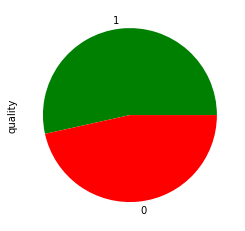

In [168]:
data_class["quality"].value_counts().plot.pie(colors=["green", "red"])

<AxesSubplot:ylabel='Frequency'>

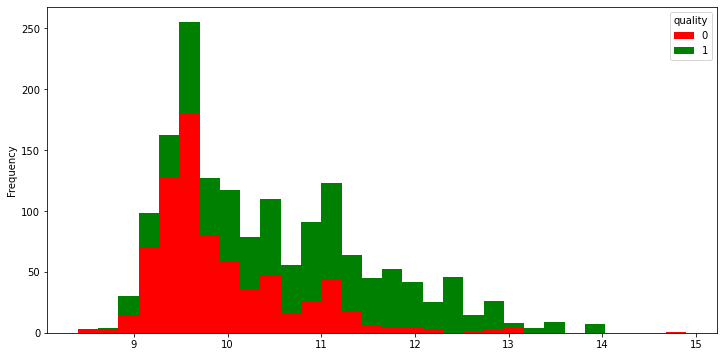

In [180]:
data_class.pivot(columns="quality")["alcohol"].plot.hist(bins=30, stacked=True, figsize=(12, 6), color=["red", "green"])

Al crescere della percentuale di alcool i vini sembrano essere di qualità maggiore

<AxesSubplot:ylabel='Frequency'>

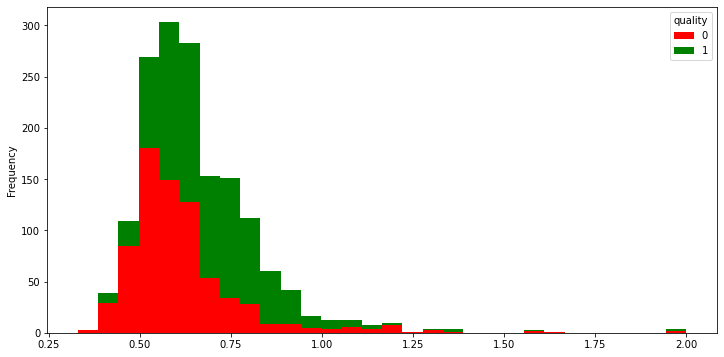

In [179]:
data_class.pivot(columns="quality")["sulphates"].plot.hist(bins=30, stacked=True, figsize=(12, 6), color=["red", "green"])

I solfiti sembrano essere associati al vino buono, entro un certo range (tra 0.6 a 1.0 circa)

<AxesSubplot:ylabel='Frequency'>

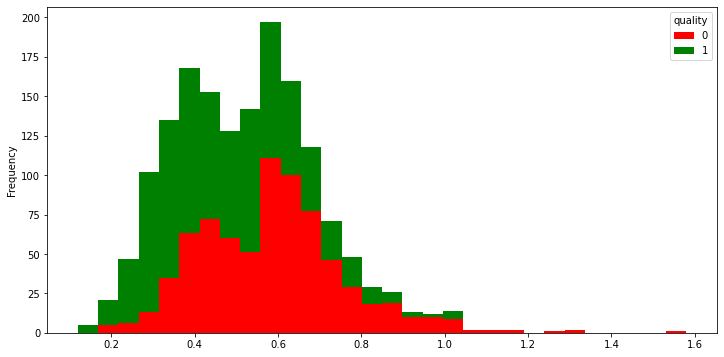

In [178]:
data_class.pivot(columns="quality")["volatile_acidity"].plot.hist(bins=30, stacked=True, figsize=(12, 6), color=["red", "green"])

All'aumento dell'acidità volatile il vino sembra essere considerato di scarsa qualità (intuitivamente ha senso, a nessuno piace un vino dal sapore acido)

<AxesSubplot:ylabel='Frequency'>

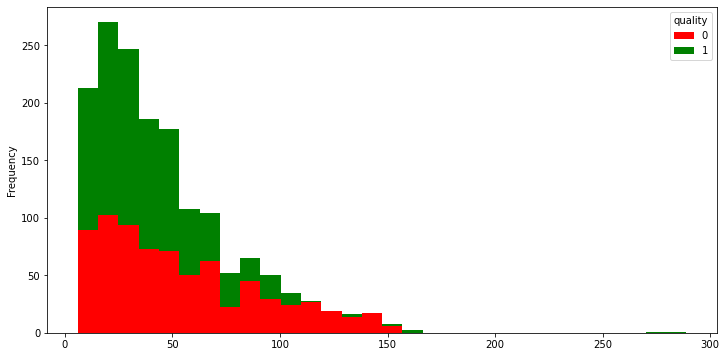

In [181]:
data_class.pivot(columns="quality")["total_sulfur_dioxide"].plot.hist(bins=30, stacked=True, figsize=(12, 6), color=["red", "green"])

Anche una quantità eccessiva di anidride solforosa sembra essere associata a vini di scarsa qualità

<AxesSubplot:ylabel='Frequency'>

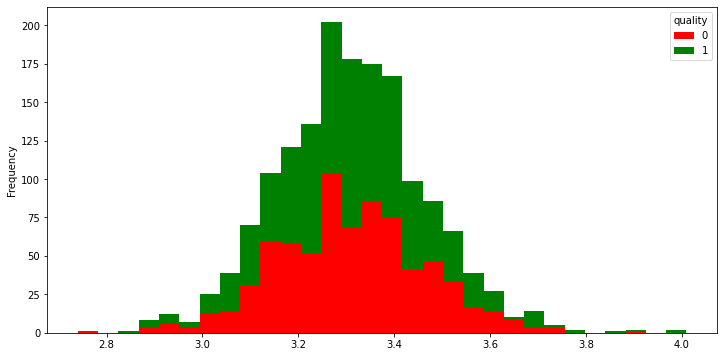

In [182]:
data_class.pivot(columns="quality")["pH"].plot.hist(bins=30, stacked=True, figsize=(12, 6), color=["red", "green"])

Il ph invece non sembra essere particolarmente rilevante ai fini della classificazione della qualità

<AxesSubplot:ylabel='Frequency'>

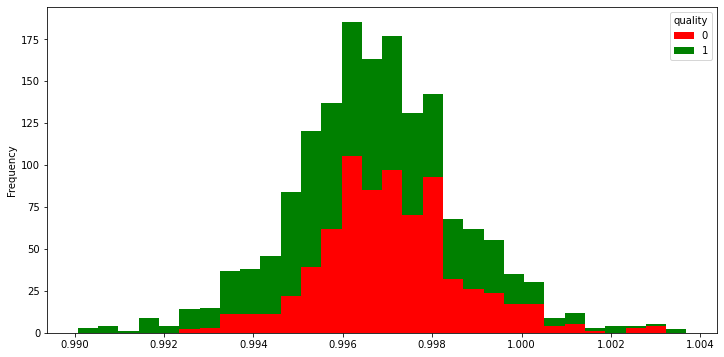

In [183]:
data_class.pivot(columns="quality")["density"].plot.hist(bins=30, stacked=True, figsize=(12, 6), color=["red", "green"])

Anche la densità non sembra avere una particolare rilevanza

## Classificazione con Perceptron

In [187]:
x_train_class, x_test_class, y_train_class, y_test_class = train_test_split(
    data_class.drop(columns="quality"), data_class["quality"], random_state=random_state
    )

In [193]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

perc_mdl = linear_model = Pipeline([
    ("scaler", StandardScaler()), 
    ("classification", Perceptron(random_state=random_state)
     )])

perc_mdl.fit(x_train_class, y_train_class)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classification', Perceptron(random_state=50))])

In [191]:
confusion_matrix(y_test_class, perc_mdl.predict(x_test_class))

array([[161,  52],
       [ 66, 121]], dtype=int64)

In [195]:
f1_score(y_test_class, perc_mdl.predict(x_test_class), average="macro")

0.702020202020202